
# PID Synthesis for a discrete second order system, with a state space feedback with LQ tuning

In [13]:
%matplotlib widget
from IPython.display import display, Math, SVG
import matplotlib.pyplot as plt

import numpy as np
from sympy import symbols, fraction, simplify, latex, collect, expand, Matrix
import control as ctrl

import pyswarms as ps

Let's consider the discrete transfer function: 
$$ H(z) = \frac{a_1 z + a_0}{z^2 + b_1 z + b_0}, $$
that is a second order continuous system discretized with a zero order hold.
The system can be written in its temporal form:
$$ y[k] =  a_1 u[k-1] + a_0 u[k-2] - b_1 y[k-1] - b_0 y[k-2],$$
with $y$ the ouput, $u$ the input and $k$ the instant considered.
This temporal form can be represented in a discrete state space system in the form:
$$ \begin{cases} \bold{x}[k+1] &= \bold{A} \bold{x}[k] + \bold{B} \bold{u}[k] \\ \bold{y}[k] &= \bold{C} \bold{x}[k]\end{cases} ,$$
with $\bold{x}\in \mathbb{R}^{2}$ the state of the system, $\bold{u}\in \mathbb{R}$ the input, $\bold{A}\in \mathbb{R}^{2\times2}$ the state matrix, $\bold{B}\in \mathbb{R}^{1\times2}$ the input matrix and $\bold{C}\in \mathbb{R}^{2\times1}$ the observation matrix. 
<img src="./misc/Block-diagram-representation-of-a-state-space-model.jpg" height="250">

Let's consider the state $\bold{x}$ with two variables $z[k]$, $y[k]$, such that $ z[k] = y[k-1] - a_0/b_0 u[k-1] $. The state space can now be expressed as:
$$ \begin{cases} \begin{pmatrix}z[k+1]\\ y[k+1]\end{pmatrix} &= \begin{pmatrix}0 & 1\\ -b_0 & -b_1\end{pmatrix} \begin{pmatrix}z[k]\\ y[k]\end{pmatrix} + \begin{pmatrix}-a_0/b_0\\ a_1\end{pmatrix} u[k] \\ y[k] &= \begin{pmatrix} 0 & 1\end{pmatrix} \begin{pmatrix}z[k]\\ y[k]\end{pmatrix}\end{cases}$$

In [14]:
# INITIAL STATE SPACE REPRESENTATION
a0, a1, b0, b1= symbols('a_0 a_1 b_0 b_1') 
A_ol = Matrix([[0,1], [-b0, -b1]])
B_ol = Matrix([[-a0/b0], [a1]])
C_ol = [0, 1]
D_ol = 0

By doing a [full state feedback](https://en.wikipedia.org/wiki/Full_state_feedback) for a given setpoint $y^*$, the correction is already equivalent to a proportional ($K_p$) derivative ($K_d$) action.
$$ u[k] = y^*[k] - \bold{K} \bold{x}[k], $$
with $\bold{K} \in \mathbb{R}^{2\times1}$ a gain matrix, such that:
$$ \bold{K} = \begin{pmatrix} K_d & K_p \end{pmatrix} $$
<img src="./misc/Block-diagram-of-a-state-feedback-controller.png" height="200">

To add an integral action, the state of the system needs to be augmented with the sum of the errors:
$$ w[k+1] = w[k] + T_e (y^*[k] - y[k]), $$
with $T_e$ the sampling time of the system, that can be written now as:
$$\begin{pmatrix}z[k+1]\\ y[k+1] \\ w[k+1]\end{pmatrix} = \begin{pmatrix}0 & 1 & 0\\ -b_0 & -b_1 & 0 \\ 0 & -T_e & 1 \end{pmatrix} \begin{pmatrix}z[k]\\ y[k] \\ w[k]\end{pmatrix} + \begin{pmatrix}-a_0/b_0\\ a_1\\0\end{pmatrix} u[k] + \begin{pmatrix}0\\ 0\\ T_e\end{pmatrix} y^*[k] $$
Then the gain matrix $\bold{K}$ can be augmented with the integral gain $K_i$ to get $\bold{K}_{PID}\in\mathbb{R}^{3\times1}$ :
$$ \bold{K}_{PID} = \begin{pmatrix} K_d & K_p & K_i\end{pmatrix} $$

In [15]:
# AUGMENTED STATE SPACE REPRESENTATION
Te = symbols('T_e') 
A_aug_ol = Matrix([[0,1, 0], [-b0, -b1, 0], [0, -Te, 1]])
B_aug_ol = Matrix([[-a0/b0], [a1], [0]]) # here we neglect the set point (the system is studied as an open loop)
C_aug_ol = [0, 1, 0]
D_aug_ol = 0

A full state feedback can only be done if all state are measured. In this case, it might not seem to be the case, however, with the measure of $y[k]$ alone, all the other state can be computed, they just need to be initiated (in most cases, a null initialization makes sense). 

By measuring the signal $y$, and considering a known initial state, then $z$ can be deduced by recording the older state of $y$, and of the command $u$ generated. The integral gain, is then just the sum of the errors $y^* - y$, and $y^*$ is known since it is the setpoint provided.

We now need to determine the gain of the matrix $\bold{K}$.

This can be achieved with a [linear quadratic](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator) (LQ) optimization, by minimizing the following cost function (that admits a solution if and only if the system is stabilizable and detectable):
$$ J = \sum_{k_0}^{+\infty} y[k]^T \bold{Q} y[k] + u[k]^T \bold{R}u[k],$$
with $\bold{Q}\in\mathbb{R}^{n\times n}$ and $\bold{R}\in\mathbb{R}^{m\times m}$, that are symetric semi definite positive weight matrices, with $n$ that is equal to the size of the state vector (3) and $m$ to the input vector (1).

The control minimizing J is the full state feedback: $u[k] = - \left( \bold{R} + \bold{B}^T\bold{P}\bold{B} \right)\bold{B}^T\bold{P}\bold{A}\bold{x}[k]$, with $\bold{P}$ the unique symmetric semi definite positive matrix that is the solution to the Riccati equation (it can be done using the control toolbox, with `dlqr`). 

Before jumping to the resolution of this quadratic optimization probleme, we need to define the weight matrices $\bold{R}$ and $\bold{Q}$. For the sake of simplicity, we will consider diagonal weight matrices. That being said, the greater the gains in $\bold{Q}$, the faster the system will respond, but with a large command (that might not be achievable in the real system), and a greater gain of $\bold{R}$ will induce a smaller command, and therefore the slower the system response.

In [16]:
r, qp, qd, qi = symbols('r q_kp q_kd q_ki') 
Q = Matrix.diag(qd, qp, qi)

As a first approximation, we will tune all the gain to 1, to see the system response when all parameters are considered equally important. The idea will then be to tuned the gains to have the fastest response, while respecting some limits on the command signal.
Let's consider the following second order system for this synthesis:
$$ H(z) =  \frac{0.008373 z + 0.001522}{z^2 - 1.622 z + 0.6322}\quad dt = 1.0$$

In [17]:
# unit weight matrices
r_t = 1
Q_t = np.array(Q.subs([(qd,1), (qp,1), (qi,1)])).astype(np.float64)
# the parameters of the second order system
b1_t = -1.6221898676716258
b0_t = 0.6322237854789634
a1_t = 0.008373147756958077
a0_t = 0.0015218514893243773
dt = 1
# state space matrices
A_t = np.array(A_aug_ol.subs([(b0, b0_t), (b1, b1_t), (Te, dt)])).astype(np.float64)
B_t = np.array(B_aug_ol.subs([(b0, b0_t), (a0, a0_t), (a1, a1_t)])).astype(np.float64)

Let's compute the $\bold{K}$ matrix with the `dlqr` function of the control toolbox:

In [18]:
K, S, E = ctrl.dlqr(A_t, B_t, Q_t, r_t)

Let's display the corrected state feedback response to the open loop response to a step input. The full state feedback system in close loop can be written as:
$$ \begin{cases} \bold{x}[k+1] &= \left(\bold{A} - \bold{B}\bold{K}\right)\bold{x}[k] + \bold{B}'y^*[k] \\ \bold{y}[k] &= \bold{C} \bold{x}[k]\end{cases} ,$$

In [19]:
# non corrected open loop response
ss_ol = ctrl.StateSpace(A_t, B_t, C_aug_ol, D_aug_ol, dt)
# full state feedback closed loop response
ss_cl = ctrl.StateSpace(A_t - B_t@K, [[0], [0], [dt]], C_aug_ol, D_aug_ol, dt)
# full state feedback closed loop command
ss_cl_u = ctrl.StateSpace(A_t - B_t@K, [[0], [0], [dt]], -K, D_aug_ol, dt) # this returns the command u
# step response
tf = 120 # final time
t = np.arange(0, tf, dt)
_, y_ol = ctrl.step_response(ss_ol, t)
_, y_cl = ctrl.step_response(ss_cl, t)
_, y_cl_u = ctrl.step_response(ss_cl_u, t)

Text(0.5, 1.0, 'Unit step response')

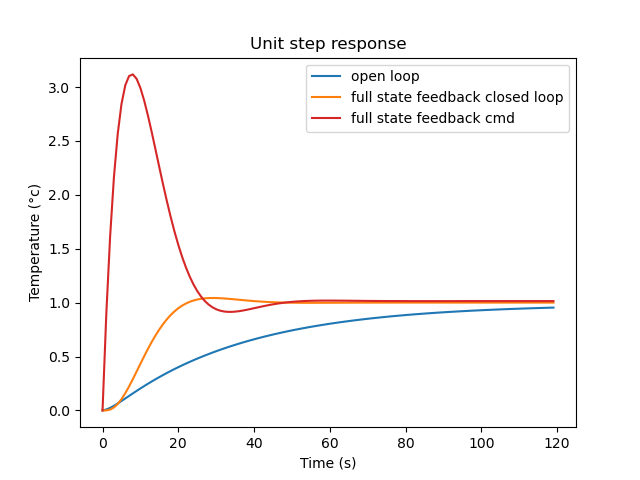

In [20]:
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax.plot(t, y_ol, color="tab:blue", label='open loop')
ax.plot(t, y_cl, color="tab:orange", label='full state feedback closed loop')
ax.plot(t, y_cl_u, color="tab:red", label='full state feedback cmd')
ax.legend()
ax.set_title("Unit step response")

The control signal reaches more than three times the setpoint value. This might be undesirable. Let's increase the weight in $\bold{R}$, to reduce the control signal.

In [21]:
# unit weight matrices
r_t = 40
Q_t = np.array(Q.subs([(qd, 1), (qp,1), (qi,1)])).astype(np.float64)
K, S, E = ctrl.dlqr(A_t, B_t, Q_t, r_t)
print(K)

[[-4.36063051  7.13433007 -0.15265329]]


In [22]:
# non corrected open loop response
ss_ol = ctrl.StateSpace(A_t, B_t, C_aug_ol, D_aug_ol, dt)
# full state feedback closed loop response
ss_cl = ctrl.StateSpace(A_t - B_t@K, [[0], [0], [dt]], C_aug_ol, D_aug_ol, dt)
# full state feedback closed loop command
ss_cl_u = ctrl.StateSpace(A_t - B_t@K, [[0], [0], [dt]], -K, D_aug_ol, dt) # this returns the command u
# step response
tf = 120 # final time
t = np.arange(0, tf, dt)
_, y_ol = ctrl.step_response(ss_ol, t)
_, y_cl = ctrl.step_response(ss_cl, t)
_, y_cl_u = ctrl.step_response(ss_cl_u, t)

In [23]:
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax.plot(t, y_ol, color="tab:blue", label='open loop')
ax.plot(t, y_cl, color="tab:orange", label='full state feedback closed loop')
ax.plot(t, y_cl_u, color="tab:red", label='full state feedback cmd')
ax.legend()
ax.set_title("Unit step response")

Text(0.5, 1.0, 'Unit step response')

In [24]:
info_y = ctrl.step_info(ss_cl, SettlingTimeThreshold=0.05)
info_u = ctrl.step_info(ss_cl_u)
print("Settling time: {}".format(info_y['SettlingTime']))
print("Max control value: {}".format(info_u['Peak']))
# ctrl.step_info(ss_cl, SettlingTimeThreshold=0.05)['SettlingTime']

Settling time: 49.0
Max control value: 1.5116067646230888


The tuning of the weight matrices can be done using [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization) (PSO) algorithm. For that we need to define a cost function considering the steady state response time and the maximal control signal value.

In [25]:
def cost_function(QR, A, B, max_desired_cmd):
    # Extract Q and R matrices from the optimization variable QR
    Q_size = np.shape(A)[0]
    R_size = np.shape(B)[1]
    Q_list = QR[:,:Q_size]
    R_list = QR[:,Q_size:]
    J = []
    for Q_param, R_param in zip(Q_list, R_list):
        Q = np.diag(Q_param).squeeze()
        R = np.diag(R_param).squeeze()
        # Compute the feedback gain matrix K using DLQR
        K, _, _ = ctrl.dlqr(A, B, Q, R)
        # full state feedback closed loop output
        ss_cl = ctrl.StateSpace(A_t - B_t@K, [[0], [0], [dt]], C_aug_ol, D_aug_ol, dt)
        # full state feedback closed loop command
        ss_cl_u = ctrl.StateSpace(A_t - B_t@K, [[0], [0], [dt]], -K, D_aug_ol, dt) # this returns the command u
        # computing the settling time and max cmd value
        try:
            settling_time = ctrl.step_info(ss_cl, SettlingTimeThreshold=0.05)['SettlingTime'] # this might fails if the response is too slow
        except:
            settling_time = 1000
        try:
            max_cmd_val = ctrl.step_info(ss_cl_u)['Peak']
        except:
            t = np.arange(0, 500, dt)
            _, cmd_vals = ctrl.step_response(ss_cl_u, t)
            max_cmd_val = max(cmd_vals)
        # Define the cost function components
        cost_settling_time = settling_time
        cost_command_response = max_cmd_val - max_desired_cmd
        if cost_command_response < 0:
            cost_command_response *= 2 # when the command is lower than the limit provided, the benefit is low
        else:
            cost_command_response *= 70 # when the command is higher than the limit provided, the penalization is very strong
        # Combine the components based on the importance of each objective
        # J.append(cost_settling_time + 10000*cost_command_response)
        J.append(settling_time + cost_command_response)
    return J

We then just have to launch the particule swarm optimization.

In [26]:
max_cmd = 1.38
dim = np.shape(A_t)[0] + np.shape(B_t)[1] # param
max_bound = 5000 * np.ones(dim) # R is a scalar
min_bound = 0 * np.ones(dim) # R is a scalar
bounds = (min_bound, max_bound)
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
kwargs={"A": A_t, "B": B_t, 'max_desired_cmd': 1.38}
# result = ps.pso(cost_function, bounds, args=(A_t, B_t, max_cmd), swarmsize=20, maxiter=100, debug=True)
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=dim, options=options, bounds=bounds)
cost, pos = optimizer.optimize(cost_function, 100, **kwargs)

2024-02-06 16:13:36,793 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=56.5
2024-02-06 16:13:45,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 56.52465348846667, best pos: [4401.48197332 2399.88065056   93.56785602 4761.37044291]


Once the optimization is done, we can recompute the $\bold{K}$ matrix with the newly estimated weight matrices $\bold{Q}$ and $\bold{R}$.

In [27]:
Q_param_size = np.shape(A_t)[0]
Q_opt = np.diag(pos[:Q_param_size]).squeeze()
r_opt = np.diag(pos[Q_param_size:]).squeeze()
print("Q_opt: {}".format(Q_opt))
print("r_opt: {}".format(r_opt))
K_opt, S_opt, E_opt = ctrl.dlqr(A_t, B_t, Q_opt, r_opt)
print("         Found K matrix corrector gain         ")
print("-----------------------------------------------")
print("K_opt: {}".format(K_opt))
print("-----------------------------------------------")

Q_opt: [[4401.48197332    0.            0.        ]
 [   0.         2399.88065056    0.        ]
 [   0.            0.           93.56785602]]
r_opt: 4761.370442911758
         Found K matrix corrector gain         
-----------------------------------------------
K_opt: [[-4.33278486  7.07347554 -0.13537393]]
-----------------------------------------------


We can now simulate the step response of the tuned full state feedback coontrol.

In [28]:
# full state feedback closed loop response
ss_cl = ctrl.StateSpace(A_t - B_t@K_opt, [[0], [0], [dt]], C_aug_ol, D_aug_ol, dt)
# full state feedback closed loop command
ss_cl_u = ctrl.StateSpace(A_t - B_t@K_opt, [[0], [0], [dt]], -K_opt, D_aug_ol, dt) # this returns the command u
# step response
tf_2 = 200 # final time
t_2 = np.arange(0, tf_2, dt)
_, y_ol = ctrl.step_response(ss_ol, t_2)
_, y_cl = ctrl.step_response(ss_cl, t_2)
_, y_cl_u = ctrl.step_response(ss_cl_u, t_2)

Text(0.5, 1.0, 'Unit step response')

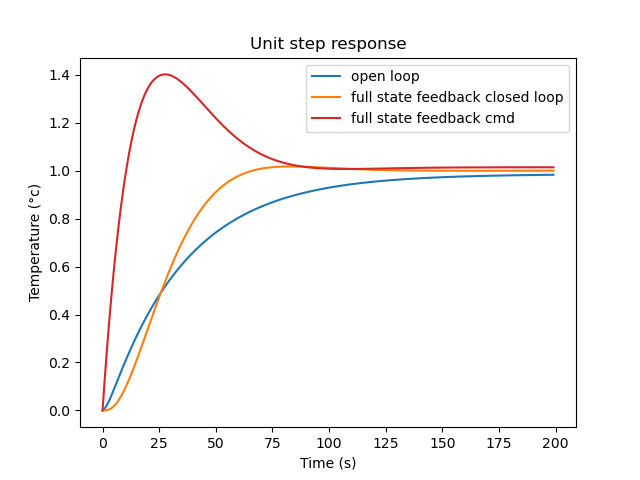

In [29]:
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax.plot(t_2, y_ol, color="tab:blue", label='open loop')
ax.plot(t_2, y_cl, color="tab:orange", label='full state feedback closed loop')
ax.plot(t_2, y_cl_u, color="tab:red", label='full state feedback cmd')
ax.legend()
ax.set_title("Unit step response")

Let's compare the state feedback reponse time to the open loop response time.

In [30]:
open_loop_settling_time = ctrl.step_info(ss_ol, SettlingTimeThreshold=0.05)['SettlingTime']
corrected_settling_time = ctrl.step_info(ss_cl, SettlingTimeThreshold=0.05)['SettlingTime']
print("Before: {}s, after correction with respected constraints: {}s".format(open_loop_settling_time, corrected_settling_time))

Before: nans, after correction with respected constraints: 55.0s


In [31]:
# np.savetxt("cmd_temperature.csv", np.array(np.stack((t_2, y_cl_u))).T, delimiter=",")

In [32]:
comsol_sim_data = np.genfromtxt("cmd_temperature.csv", delimiter=';', skip_header=1, encoding='latin1')

In [34]:
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax.plot(t_2, y_ol, color="tab:blue", label='open loop')
ax.plot(t_2, y_cl, color="tab:orange", label='full state feedback closed loop')
ax.plot(t_2, y_cl_u, color="tab:red", label='full state feedback cmd')
ax.plot(comsol_sim_data[:,0], comsol_sim_data[:,2]/110, color='tab:purple', label="comsol sim")
ax.legend()
ax.set_title("Unit step response")

Text(0.5, 1.0, 'Unit step response')